In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
import random
import csv

In [63]:
def is_power_of_two(n):
  return (n & (n - 1) == 0) and n != 0


def generate_cache_accesses_aligned(num_operations=500,
                            address_start=0,
                            address_end=4096,
                            repeat_percentage_range=(30, 70)):
  
  addresses = list(range(address_start, address_end, 4))

  # Generate a list of data values
  data_values = [
      "0x11111111",
      "0x22222222",
      "0x33333333",
      "0x44444444",
      "0x55555555",
      "0x66666666",
      "0x77777777",
      "0x88888888",
      "0x99999999",
      "0x12345678",
      "0x79824691",
      "0x16420982",
      "0x15946378",
      "0x687b890a",
      "0xf809b234",
  ]

  num_repeated_operations = int(num_operations *
                                random.uniform(*repeat_percentage_range) / 100)
  num_unique_operations = num_operations - num_repeated_operations

  unique_accesses = []
  for _ in range(num_unique_operations):
    address = random.choice(addresses)
    if random.choice([True, False]):
      unique_accesses.append(["R", f"0x{address:08X}", ""])
    else:
      data = random.choice(data_values)
      unique_accesses.append(["W", f"0x{address:08X}", data])

  repeated_accesses = random.choices(unique_accesses,
                                     k=num_repeated_operations)

  accesses = unique_accesses + repeated_accesses
  random.shuffle(accesses) 

  return accesses


def save_accesses_to_csv(num_operations=500):
  accesses = generate_cache_accesses_aligned(num_operations=num_operations)

  file_path = f"cache_accesses_{num_operations}.csv"

  with open(file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Operation", "Address", "Data"])
    writer.writerows(accesses)

  print(f"Generated cache accesses and saved to {file_path}")

In [64]:



def run_c_program(cache_line_size, l1_cache_lines, l2_cache_lines):
  command = [
      "./project", "-c", "10000000", "--cacheline-size",
      str(cache_line_size), "--l1-lines",
      str(l1_cache_lines), "--l2-lines",
      str(l2_cache_lines), "--l1-latency", "4", "--l2-latency", "16",
      "--memory-latency", "400", "--tf=tracefile", f"cache_accesses_500.csv"
  ]

  result = subprocess.run(command, capture_output=True, text=True)
  if result.returncode != 0:
    print(f"Error running C program: {result.stderr}")

In [65]:
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']

def read_results_from_csv(filename):
  if os.path.exists(filename):
    return pd.read_csv(filename, names=column_names, header=None)

In [66]:
save_accesses_to_csv(500)

Generated cache accesses and saved to cache_accesses_500.csv


In [73]:
cache_line_sizes = [8, 16, 32, 64, 128]
l1_cache_lines = [16, 32, 64]
l2_cache_lines = [64, 128, 256]
column_names = ['cycles', 'misses', 'hits', 'primitiveGateCount']
results_df = pd.DataFrame()
for i in range(10):
  generate_cache_accesses_aligned(500)
  for cache_line_size in [32]:
    for l1_lines in [32]:
      for l2_lines in l2_cache_lines:
        run_c_program(cache_line_size, l1_lines, l2_lines)
        filename = 'results.csv'
        df = pd.DataFrame()
        df = read_results_from_csv(filename)
        df['cache_line_size'] = cache_line_size
        df['l1_cache_lines'] = l1_lines
        df['l2_cache_lines'] = l2_lines
        results_df = pd.concat([results_df,df], ignore_index=True)

print(results_df)

    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0   829402     570   359               47749               32              32   
1   448602     451   478               65413               32              32   
2   448602     451   478              100613               32              32   
3   829402     570   359               47749               32              32   
4   448602     451   478               65413               32              32   
5   448602     451   478              100613               32              32   
6   829402     570   359               47749               32              32   
7   448602     451   478               65413               32              32   
8   448602     451   478              100613               32              32   
9   829402     570   359               47749               32              32   
10  448602     451   478               65413               32              32   
11  448602     451   478    

     cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines
0    374174     807   166               13503                8              16
1    303774     719   254               19007                8              16
2    263774     669   304               29887                8              16
3    373598     771   187               14909                8              32
4    303198     683   275               20413                8              32
..      ...     ...   ...                 ...              ...             ...
409  303198     683   275               20413                8              32
410  263198     633   325               31293                8              32
411  372430     698   219               17691                8              64
412  302030     610   307               23195                8              64
413  262030     560   357               34075                8              64

[90 rows x 6 columns]
     cycles  misses  hits  pr

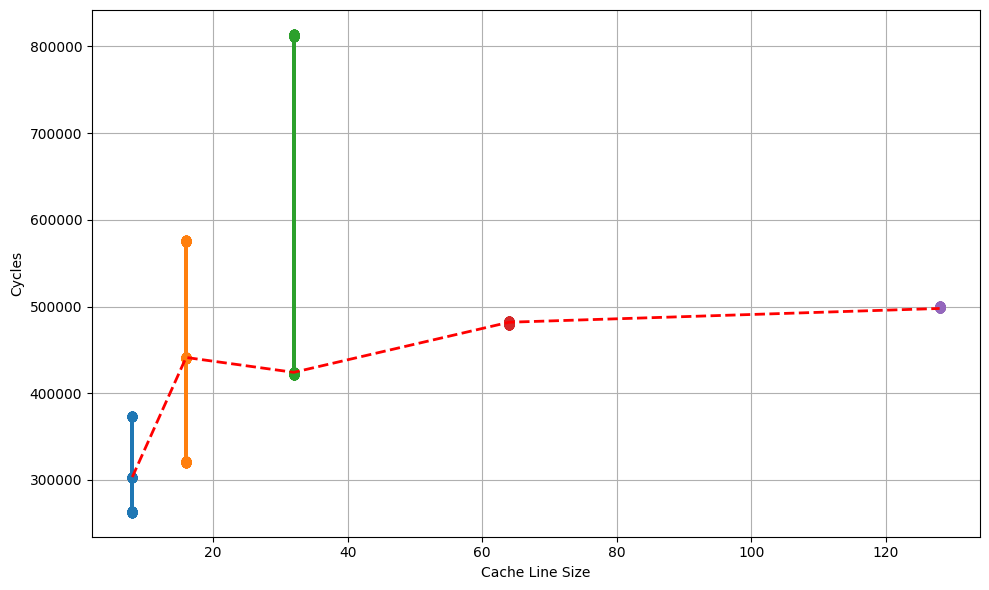

In [58]:
plt.figure(figsize=(10, 6))

for cls in cache_line_sizes:
  subset = results_df[results_df['cache_line_size'] == cls]
  print(subset)
  plt.plot(subset['cache_line_size'],
           subset['cycles'],
           label=f'Cache Line Size {cls}',
           marker='o',
           linestyle='-')

median_values = results_df.groupby(
    'cache_line_size')['cycles'].median().reset_index()

plt.plot(median_values['cache_line_size'],
         median_values['cycles'],
         color='red',
         linestyle='--',
         linewidth=2,
         label='Median of Cycles')

plt.xlabel("Cache Line Size")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0   449930     534   430               96167               32              16   
3   449930     534   430               96167               32              16   
6   449930     534   430               96167               32              16   
9   449930     534   430               96167               32              16   
12  449930     534   430               96167               32              16   
15  449930     534   430               96167               32              16   
18  449930     534   430               96167               32              16   
21  449930     534   430               96167               32              16   
24  449930     534   430               96167               32              16   
27  449930     534   430               96167               32              16   

    l2_cache_lines  
0              256  
3              256  
6              256  
9              256  
12 

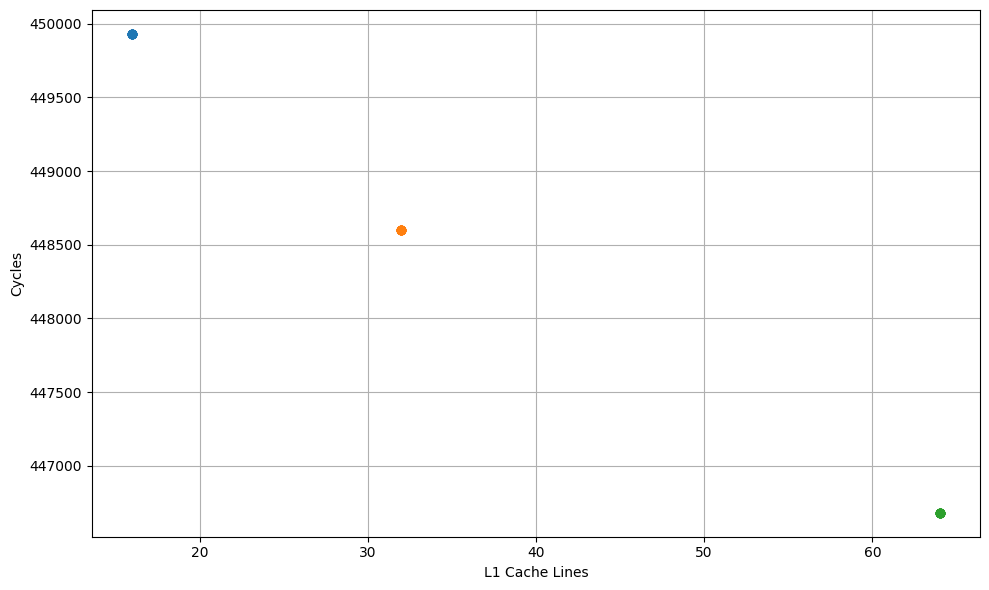

In [72]:
plt.figure(figsize=(10, 6))


for l1s in l1_cache_lines:
  subset = results_df[results_df['l1_cache_lines'] == l1s]
  print(subset)
  plt.plot(subset['l1_cache_lines'],
           subset['cycles'],
           label=f'l1_cache_lines {l1s}',
           marker='o',
           linestyle='-')
  
plt.xlabel("L1 Cache Lines")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

    cycles  misses  hits  primitiveGateCount  cache_line_size  l1_cache_lines  \
0   829402     570   359               47749               32              32   
3   829402     570   359               47749               32              32   
6   829402     570   359               47749               32              32   
9   829402     570   359               47749               32              32   
12  829402     570   359               47749               32              32   
15  829402     570   359               47749               32              32   
18  829402     570   359               47749               32              32   
21  829402     570   359               47749               32              32   
24  829402     570   359               47749               32              32   
27  829402     570   359               47749               32              32   

    l2_cache_lines  
0               64  
3               64  
6               64  
9               64  
12 

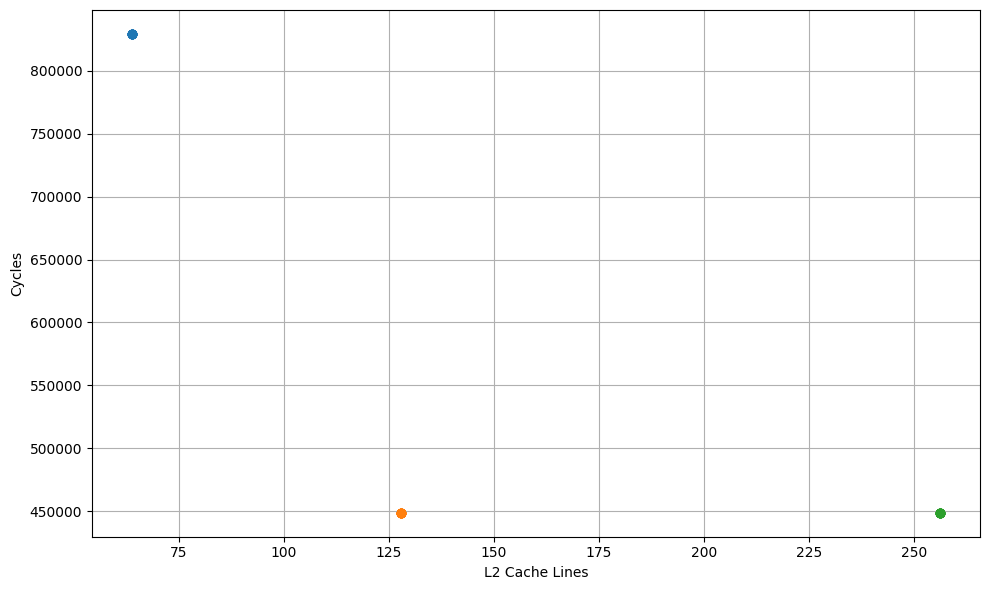

In [75]:
plt.figure(figsize=(10, 6))


for l2s in l2_cache_lines:
  subset = results_df[results_df['l2_cache_lines'] == l2s]
  print(subset)
  plt.plot(subset['l2_cache_lines'],
           subset['cycles'],
           label=f'l1_cache_lines {l2s}',
           marker='o',
           linestyle='-')
  
plt.xlabel("L2 Cache Lines")
plt.ylabel("Cycles")
plt.grid(True)
plt.tight_layout()
plt.show()